In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.signal import resample

from sklearn.metrics import confusion_matrix

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing import sequence

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

import tensorflow as tf
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField
from pyts.image import MarkovTransitionField
from pyts.image import RecurrencePlot

In [2]:
main_path = 'C:\\Users\\jagat\\Desktop\\Masters\\Team Project\\UTD\\Inertial/'
data_inertial_lists=os.listdir(main_path)

In [3]:
data_inertial_lists[-3]

'a9_s8_t2_inertial.mat'

In [4]:
random_name = data_inertial_lists[-8]
random_test = sio.loadmat(main_path+random_name)
random_test_name = random_name.split('/')[-1].split('.')[0]
random_test

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Jan 01 01:48:40 2015',
 '__version__': '1.0',
 '__globals__': [],
 'd_iner': array([[-1.0026860e+00, -2.9126000e-01, -2.2241200e-01,  1.2305344e+01,
          1.7099237e+01,  7.2977100e+00],
        [-1.0043950e+00, -3.0566400e-01, -2.0214800e-01,  5.9847330e+00,
          1.8442748e+01,  6.2900760e+00],
        [-9.8461900e-01, -3.2202100e-01, -1.7871100e-01,  1.8015270e+00,
          2.0854962e+01,  4.3053440e+00],
        ...,
        [-1.0356450e+00, -1.4184600e-01, -1.7090000e-02, -1.8625950e+00,
          3.7251910e+00, -4.5190840e+00],
        [-1.0375980e+00, -1.1743200e-01, -3.7842000e-02, -7.9694660e+00,
          3.2366410e+00, -5.6488550e+00],
        [-1.0380860e+00, -9.3262000e-02, -4.1016000e-02, -2.3267176e+01,
          3.0534350e+00, -5.9236640e+00]])}

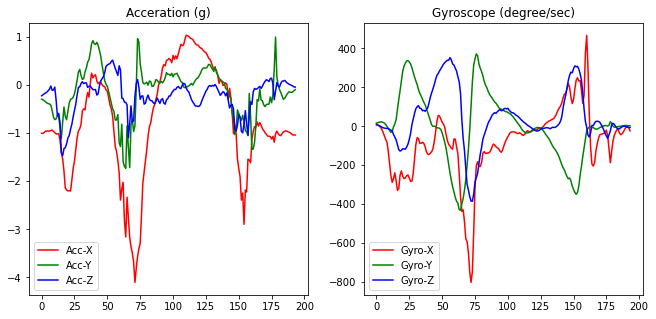

In [5]:
inertial_info = random_test['d_iner']
acc_x = inertial_info[:,0]
acc_y = inertial_info[:,1]
acc_z = inertial_info[:,2]

gyro_x = inertial_info[:,3]
gyro_y = inertial_info[:,4]
gyro_z = inertial_info[:,5]

%matplotlib inline
fig, ax = plt.subplots(1,2, sharex=True, figsize = (11,5))
a, = ax[0].plot(acc_x, c = 'r')
a_2,= ax[0].plot(acc_y, c = 'g')
a_3, = ax[0].plot(acc_z, c = 'b')
ax[0].set_title('Acceration (g)')
ax[0].legend([a,a_2,a_3], ['Acc-X', 'Acc-Y', 'Acc-Z'])

g, = ax[1].plot(gyro_x, c = 'r')
g_2, = ax[1].plot(gyro_y, c = 'g')
g_3, = ax[1].plot(gyro_z, c = 'b')
ax[1].set_title('Gyroscope (degree/sec)')

ax[1].legend([g,g_2,g_3], ['Gyro-X', 'Gyro-Y', 'Gyro-Z'])


plt.show()

In [6]:
class_labels = ['swipe left','swipe right','wave','clap','throw','arm cross','basketball shoot','draw x','draw circle CW','draw circle CCW','draw triangle',
               'bowling','boxing','baseball swing','tennis swing','arm curl','tennis serve','push','knock','catch','pickup throw']

def find_action_number(path):
    return int(path.split('/')[-1].split('_')[0][1:])

def get_subject_number(path):
    return int(path.split('/')[-1].split('_')[1][1:])

In [2]:
import pandas as pd
df = pd.DataFrame({"ALS setting": ["ALS1", "ALS1", "ALS1", "ALS1", "ALS1",
                         "ALS2", "ALS2", "ALS2", "ALS2", "ALS2"],
                   "HOT Users RMSE": [2, 3, 5, 3, 0,
                         1, 1.5, 1.5, 1.6, 8],
                   "COOL Users RMSE": [2, 4, 5, 5, 6, 6, 8, 9, 9,7]})
pd.DataFrame({"ALS setting": ["ALS1", "ALS1", "ALS1", "ALS1", "ALS1",
                         "ALS2", "ALS2", "ALS2", "ALS2", "ALS2"],
                           "Split_num":[1,2,3,4,5,1,2,3,4,5],
                           "HOT Users RMSE": [2, 3, 5, 3, 0,
                         1, 1.5, 1.5, 1.6, 8],
                           "COOL Users RMSE": [2, 4, 5, 5, 6, 6, 8, 9, 9,7]})

,ALS setting,Split_num,HOT Users RMSE,COOL Users RMSE
0,ALS1,1,2.0,2
1,ALS1,2,3.0,4
2,ALS1,3,5.0,5
3,ALS1,4,3.0,5
4,ALS1,5,0.0,6
5,ALS2,1,1.0,6
6,ALS2,2,1.5,8
7,ALS2,3,1.5,9
8,ALS2,4,1.6,9
9,ALS2,5,8.0,7


# train on subject 5,6,7,8
# test on subject 1,2,3,4
X_train = []
Y_train = []
X_test = []
Y_test = []

resample_len = 180

for path in data_inertial_lists:
        if get_subject_number(path) in [5,6,7,8]:
            X_train.append(path)
            Y_train.append(find_action_number(path))
        else:
            X_test.append(path)
            Y_test.append(find_action_number(path))

X_train = [resample(sio.loadmat(main_path+x)['d_iner'], resample_len) for x in X_train]
X_test = [resample(sio.loadmat(main_path+x)['d_iner'], resample_len) for x in X_test]


X_train = np.array(X_train)
X_test = np.array(X_test)

Y_train = to_categorical(np.array(Y_train) - 1)
Y_test = to_categorical(np.array(Y_test) - 1)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

X_raw,y_raw=[],[]
for path in data_inertial_lists:
    X_raw.append(path)
    y_raw.append(find_action_number(path))
    
X_all= [sio.loadmat(main_path+x)['d_iner'] for x in X_raw]
y_all= to_categorical(np.array(y_raw) - 1)

sio.loadmat(main_path+X_raw[0])['d_iner'][:,5].shape

In [7]:
actvs=['None']*21
for i in range(len(class_labels)):
    actvs[i]=[]
    for path in data_inertial_lists:
        if find_action_number(path)==i+1:
            actvs[i].append(path)
#actvs

In [8]:
new_X_=['None']*21
resample_len= 192
for i in range(len(actvs)):
    new_X_[i]=[]
    for path in actvs[i]:
        #caps= sio.loadmat(main_path + path)['d_iner']
        caps= resample(sio.loadmat(main_path+path)['d_iner'], resample_len)
        new_X_[i].append(caps)
    #new_X_[i]= np.array(new_X_[i],dtype=object)
new_X_=np.array(new_X_,dtype=object)

In [9]:
XPn=[]
for i in range(len(new_X_)):
    #XPn[i]=[]
    a=new_X_[i][0]
    for j in range(len(new_X_[i])-1):
        b=new_X_[i][j+1]
        vast= np.vstack((a,b))
        a = vast
    XPn.append(np.array(vast, dtype=object))
XPn=np.array(XPn, dtype=object)

In [10]:
def extract_sliding_windows(df_data, windows, steps, label):
    num_features = 6
    window_segments = []
    label_segments = []

    for i in range(0, (df_data.shape[0])-windows, steps):
        acc_x = df_data[:,0][i: i+windows]
        acc_y = df_data[:,1][i: i+windows]
        acc_z = df_data[:,2][i: i+windows]
        gyro_x = df_data[:,3][i: i+windows]
        gyro_y = df_data[:,4][i: i+windows]
        gyro_z = df_data[:,5][i: i+windows]
        #_label = df_data['label'][i: i+windows]
        #label = Counter(_label).most_common()[0][0]
        window_segments.append([acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z])
        label_segments.append(label)

    window_segments_reshape = np.asarray(window_segments, dtype= np.float32).transpose(0,2,1)#.reshape(-1, windows, num_features)
    label_segments = np.asarray(label_segments)

    return window_segments_reshape, label_segments

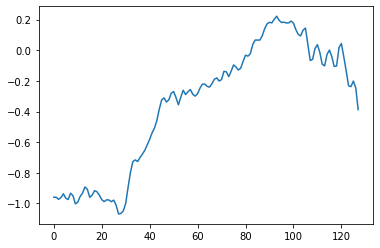

In [11]:
plt.plot(XPn[0][:128,0])

In [12]:
# 50% overlap
overlap_per=50
windows = 128 #  resample_len
steps = int(windows*(1-(overlap_per/100))) #64 #int(resample_len*0.5)
window_segments_reshape, label_segments = [], [] # window_segments_label_segments(df, windows, steps)
X_fin,y_fin= extract_sliding_windows(XPn[0], windows, steps, 1)
for i in range(len(XPn)-1):
    b= extract_sliding_windows(XPn[i+1], windows, steps, i+2)
    X_s= np.concatenate((X_fin, b[0]))
    y_s= np.concatenate((y_fin, b[1]))
    X_fin= X_s
    y_fin= y_s

In [13]:
X_fin.shape

(1971, 128, 6)

X_fin=X_fin.transpose(0,2,1)

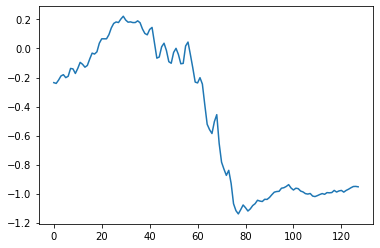

In [14]:
plt.plot(X_fin[1][:,0])

In [15]:
y_tr = to_categorical(y_fin)
final_Y = np.delete(y_tr,0,1)
final_Y.shape

(1971, 21)

In [16]:
np.random.seed(42)
rand_indices= np.random.permutation(X_fin.shape[0])
X_fin= X_fin[rand_indices]
final_Y= final_Y[rand_indices]

#80,20 split
split= int(0.7*final_Y.shape[0])
train_split= rand_indices[:split]
test_split= rand_indices[split:]

In [17]:
X_train= X_fin[train_split]
X_test= X_fin[test_split]
Y_train= final_Y[train_split]
Y_test= final_Y[test_split]

In [18]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1379, 128, 6), (1379, 21), (592, 128, 6), (592, 21))

In [19]:
def plot_graphs(history):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    plt.plot(train_acc, 'C0', label='train')
    plt.plot(val_acc, 'C1', label='test')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy") 
    plt.title("Epoch vs Accuracy")
    plt.legend()
    plt.show()

    train_acc = history.history['loss']
    val_acc = history.history['val_loss']
    plt.plot(train_acc, 'C0', label='train')
    plt.plot(val_acc, 'C1', label='test')
    plt.xlabel("Epochs")
    plt.ylabel("Loss") 
    plt.title("Epoch vs Loss")
    plt.legend()
    plt.show()

def calc_scores(history):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    return len(train_acc),train_acc[-1]*100,val_acc[-1]*100

scores=np.zeros(shape=(7,3))

Model: "CNN_1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 126, 20)           380       
                                                                 
 dropout (Dropout)           (None, 126, 20)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 63, 20)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 61, 400)           24400     
                                                                 
 dropout_1 (Dropout)         (None, 61, 400)           0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 30, 400)          0         
 1D)                                                        

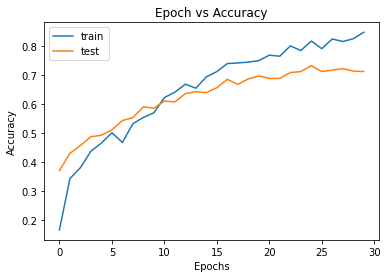

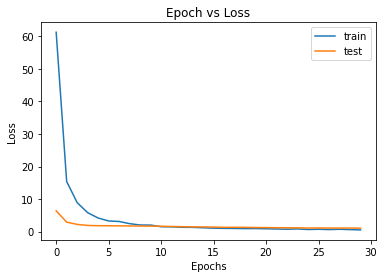

In [20]:
np.random.seed(0)
model_simple_CNN = Sequential(name = 'CNN_1D')
model_simple_CNN.add(Conv1D(filters=20, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2]))) #(128,6)
model_simple_CNN.add(Dropout(0.5))
model_simple_CNN.add(MaxPooling1D(pool_size=2))
model_simple_CNN.add(Conv1D(filters=400, kernel_size=3, activation='relu'))
model_simple_CNN.add(Dropout(0.5))
model_simple_CNN.add(MaxPooling1D(pool_size=2))
model_simple_CNN.add(Flatten())
model_simple_CNN.add(Dropout(0.5))
model_simple_CNN.add(Dense(21, activation='softmax'))
model_simple_CNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_simple_CNN.summary())

LOG_DIR = os.path.join(os.getcwd(), 'logs')

os.chdir(os.getcwd())

tb = TensorBoard(LOG_DIR)

weights_dir = 'weights/' + model_simple_CNN.name + \
            '-{epoch:02d}-{loss:.2f}'
chkpt = ModelCheckpoint(filepath=weights_dir, monitor='loss', save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)

early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=3)


history = model_simple_CNN.fit(X_train, Y_train , epochs=30, 
                    validation_data=(X_test, Y_test ), callbacks=[tb, chkpt])

plot_graphs(history)
scores[0,:]=calc_scores(history)

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1062912   
                                                                 
 dense_1 (Dense)             (None, 100)               51300     
                                                                 
 dense_2 (Dense)             (None, 21)                2121      
                                                                 
Total params: 1,116,333
Trainable params: 1,116,333
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
44/44 [==============================] - 77s 2s/step - loss: 2.8994 - accuracy: 0.1378 - val_loss: 2.7097 - val_accuracy: 0.1943
Epoch 2/20
44/44 [==============================] - 86s 2s/step - loss: 2.3505 - accuracy: 0.3358 - val_loss: 2.4651 - val_accuracy: 0.2872
Epoch 3/20
44/44 [=============

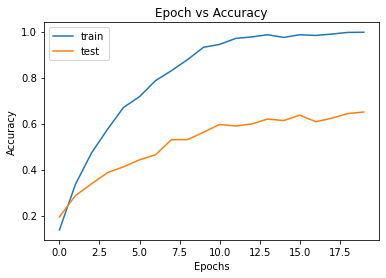

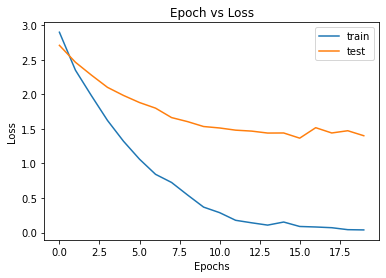

In [21]:
np.random.seed(0)
model_LSTM = Sequential(name = 'LSTM')
model_LSTM.add(LSTM(512, recurrent_dropout=0.3, input_shape=(None, X_train.shape[2]))) 
model_LSTM.add(Dense(100, activation='relu'))
model_LSTM.add(Dense(21, activation='softmax'))
model_LSTM.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=5e-4), metrics=['accuracy'])
print(model_LSTM.summary())

LOG_DIR = os.path.join(os.getcwd(), 'logs')

os.chdir(os.getcwd())

tb = TensorBoard(LOG_DIR)

weights_dir = 'weights/' + model_LSTM.name + \
            '-{epoch:02d}-{loss:.2f}'
chkpt = ModelCheckpoint(filepath=weights_dir, monitor='accuracy', save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)

early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=3)


history = model_LSTM.fit(X_train, Y_train , epochs=20, 
                    validation_data=(X_test, Y_test ), callbacks=[tb, chkpt])

plot_graphs(history)
scores[1,:]=calc_scores(history)

In [22]:
np.random.seed(0)
model_biLSTM = Sequential(name = 'bidirectional_LSTM')
model_biLSTM.add(Bidirectional(LSTM(512, recurrent_dropout=0.3), input_shape=(None, X_train.shape[2])))
model_biLSTM.add(Dense(100, activation='relu'))
model_biLSTM.add(Dense(21, activation='softmax'))
model_biLSTM.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
print(model_biLSTM.summary())

LOG_DIR = os.path.join(os.getcwd(), 'logs')

os.chdir(os.getcwd())

tb = TensorBoard(LOG_DIR)

weights_dir = 'weights/' + model_biLSTM.name + \
            '-{epoch:02d}-{loss:.2f}'
chkpt = ModelCheckpoint(filepath=weights_dir, monitor='accuracy', save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)

early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=3)


history = model_biLSTM.fit(X_train, Y_train , epochs=15,
                    validation_data=(X_test, Y_test ), callbacks=[tb, chkpt])

plot_graphs(history)
scores[2,:]=calc_scores(history)

Model: "bidirectional_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1024)             2125824   
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 100)               102500    
                                                                 
 dense_4 (Dense)             (None, 21)                2121      
                                                                 
Total params: 2,230,445
Trainable params: 2,230,445
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
44/44 [==============================] - 157s 3s/step - loss: 2.5841 - accuracy: 0.2429 - val_loss: 2.1343 - val_accuracy: 0.3750
Epoch 2/15
44/44 [==============================] - 152s 3s/step - loss: 1.3787 - accuracy

KeyboardInterrupt: 

In [ ]:
acv=X_train[0,:,3]
plt.plot(acv)
plt.show()
factor=4
k=int(len(acv)/factor)
transformer1 = MarkovTransitionField(image_size=1/factor)#,strategy='uniform')
transformer2 = GramianAngularField(image_size=1/factor)
transformer3 = RecurrencePlot(threshold=0.5)
transformer4 = RecurrencePlot(threshold=10)
p=transformer1.transform(acv.reshape(1,-1))
q=transformer2.transform(acv.reshape(1,-1))
r=transformer4.transform(acv.reshape(1,-1))
print(p.shape)
plt.imshow(p.reshape(k,k));
plt.show()
plt.imshow(q.reshape(k,k));
plt.show()
plt.imshow(r.reshape(factor*k,factor*k));
plt.show()
avg_filt=layers.AveragePooling2D((factor, factor))
plt.imshow(avg_filt(r.reshape(1,len(acv),len(acv),1)).reshape(k,k));

In [ ]:
def new_X_MTF(X):
    Xp=np.zeros(shape=(X.shape[0],k,k,X.shape[2]))
    for i in range(X.shape[0]):
        for j in range(X.shape[2]):
            dt=X[i,:,j]
            img=transformer1.transform(dt.reshape(1,-1))
            Xp[i,:,:,j]=img
    return Xp

X_MTF_train=new_X_MTF(X_train)
X_MTF_test=new_X_MTF(X_test)
x1,x2,x3,x4= X_MTF_train.shape
print(x1,x2,x3,x4)

In [ ]:
np.random.seed(0)
model_MTF = models.Sequential()
model_MTF.add(layers.Conv3D(100, (4, 4, 2), activation='selu', input_shape=(x2,x3, x4, 1)))
model_MTF.add(layers.MaxPooling3D((2, 2, 1)))
model_MTF.add(layers.Conv3D(10, (5, 5, 4), activation='selu'))
model_MTF.add(layers.MaxPooling3D((2, 2, 1)))
#model_MTF.add(layers.Conv3D(20, (6, 6, 2), activation='relu'))
#model_MTF.add(layers.MaxPooling3D((2, 2, 1)))
model_MTF.add(layers.Flatten())
model_MTF.add(Dropout(0.5))
model_MTF.add(layers.Dense(100, activation='relu'))
model_MTF.add(Dropout(0.5))
model_MTF.add(layers.Dense(21, activation='softmax'))
print(model_MTF.summary())


model_MTF.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
LOG_DIR = os.path.join(os.getcwd(), 'logs')

os.chdir(os.getcwd())

tb = TensorBoard(LOG_DIR)

weights_dir = 'weights/' + model_MTF.name + \
            '-{epoch:02d}-{loss:.2f}'
chkpt = ModelCheckpoint(filepath=weights_dir, monitor='loss', save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)

early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=3)

history = model_MTF.fit(X_MTF_train, Y_train , epochs=15, 
                    batch_size=3, validation_data=(X_MTF_test, Y_test), callbacks=[tb, chkpt])

plot_graphs(history)
scores[3,:]=calc_scores(history)

In [ ]:
def new_X_GAF(X):
    Xp=np.zeros(shape=(X.shape[0],k,k,X.shape[2]))
    for i in range(X.shape[0]):
        for j in range(X.shape[2]):
            dt=X[i,:,j]
            img=transformer2.transform(dt.reshape(1,-1))
            Xp[i,:,:,j]=img
    return Xp

X_GAF_train=new_X_GAF(X_train)
X_GAF_test=new_X_GAF(X_test)
x1,x2,x3,x4= X_GAF_train.shape
print(x1,x2,x3,x4)

In [ ]:
np.random.seed(0)
model_GAF = models.Sequential()
model_GAF.add(layers.Conv3D(100, (4, 4, 2), activation='selu', input_shape=(x2,x3, x4, 1)))
model_GAF.add(layers.MaxPooling3D((2, 2, 1)))
model_GAF.add(layers.Conv3D(10, (5, 5, 4), activation='selu'))
model_GAF.add(layers.MaxPooling3D((2, 2, 1)))
#model_GAF.add(layers.Conv3D(20, (6, 6, 2), activation='relu'))
#model_GAF.add(layers.MaxPooling3D((2, 2, 1)))
model_GAF.add(layers.Flatten())
model_GAF.add(Dropout(0.5))
model_GAF.add(layers.Dense(100, activation='relu'))
model_GAF.add(Dropout(0.5))
model_GAF.add(layers.Dense(21, activation='softmax'))
print(model_GAF.summary())


model_GAF.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
LOG_DIR = os.path.join(os.getcwd(), 'logs')

os.chdir(os.getcwd())

tb = TensorBoard(LOG_DIR)

weights_dir = 'weights/' + model_GAF.name + \
            '-{epoch:02d}-{loss:.2f}'
chkpt = ModelCheckpoint(filepath=weights_dir, monitor='loss', save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)

early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=3)

history = model_GAF.fit(X_GAF_train, Y_train , epochs=15, 
                    batch_size=3, validation_data=(X_GAF_test, Y_test), callbacks=[tb, chkpt])

plot_graphs(history)
scores[4,:]=calc_scores(history)

In [ ]:
def new_X_RP(X):
    Xp=np.zeros(shape=(X.shape[0],k,k,X.shape[2]))
    for i in range(X.shape[0]):
        for j in range(X.shape[2]):
            dt=X[i,:,j]
            if j<3:
                img=transformer3.transform(dt.reshape(1,-1))
            else:
                img=transformer4.transform(dt.reshape(1,-1))
            img=avg_filt(img.reshape(1,180,180,1)).reshape(k,k)
            Xp[i,:,:,j]=img
    return Xp

X_RP_train=new_X_RP(X_train)
X_RP_test=new_X_RP(X_test)
x1,x2,x3,x4= X_RP_train.shape
print(x1,x2,x3,x4)

In [ ]:
np.random.seed(0)
model_RP = models.Sequential()
model_RP.add(layers.Conv3D(100, (4, 4, 2), activation='selu', input_shape=(x2,x3, x4, 1)))
model_RP.add(layers.MaxPooling3D((2, 2, 1)))
model_RP.add(layers.Conv3D(10, (5, 5, 4), activation='selu'))
model_RP.add(layers.MaxPooling3D((2, 2, 1)))
#model_RP.add(layers.Conv3D(20, (6, 6, 2), activation='relu'))
#model_RP.add(layers.MaxPooling3D((2, 2, 1)))
model_RP.add(layers.Flatten())
model_RP.add(Dropout(0.5))
model_RP.add(layers.Dense(100, activation='relu'))
model_RP.add(Dropout(0.5))
model_RP.add(layers.Dense(21, activation='softmax'))
print(model_RP.summary())


model_RP.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
LOG_DIR = os.path.join(os.getcwd(), 'logs')

os.chdir(os.getcwd())

tb = TensorBoard(LOG_DIR)

weights_dir = 'weights/' + model_RP.name + \
            '-{epoch:02d}-{loss:.2f}'
chkpt = ModelCheckpoint(filepath=weights_dir, monitor='loss', save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)

early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=3)

history = model_RP.fit(X_RP_train, Y_train , epochs=15, 
                    batch_size=3, validation_data=(X_RP_test, Y_test), callbacks=[tb, chkpt])

plot_graphs(history)
scores[5,:]=calc_scores(history)

In [ ]:
def new_X_all(X):
    Xp=np.zeros(shape=(X.shape[0],k,k,X.shape[2]*3))
    for i in range(X.shape[0]):
        for j in range(X.shape[2]):
            dt=X[i,:,j]
            img1=transformer1.transform(dt.reshape(1,-1))
            Xp[i,:,:,3*j]=img1
            img2=transformer2.transform(dt.reshape(1,-1))
            Xp[i,:,:,3*j+1]=img2
            if j<3:
                img3=transformer3.transform(dt.reshape(1,-1))
            else:
                img3=transformer4.transform(dt.reshape(1,-1))
            img3=avg_filt(img3.reshape(1,len(acv),len(acv),1)).reshape(k,k)
            Xp[i,:,:,3*j+2]=img3
    return Xp

X_all_img_train=new_X_all(X_train)
X_all_img_test=new_X_all(X_test)
x1,x2,x3,x4= X_all_img_train.shape
print(x1,x2,x3,x4)

In [ ]:
np.random.seed(0)
model = models.Sequential()
model.add(layers.Conv3D(10, (5, 5, 2), activation='selu', input_shape=(x2,x3, x4, 1)))
model.add(layers.MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.5))
model.add(layers.Conv3D(50, (3, 3, 3), activation='selu'))
model.add(layers.MaxPooling3D((2, 2, 2)))
#model.add(layers.Conv3D(20, (6, 6, 2), activation='relu'))
#model.add(layers.MaxPooling3D((2, 2, 1)))
model.add(layers.Flatten())
#model.add(Dropout(0.5))
#model.add(layers.Dense(100, activation='relu'))
#model.add(Dropout(0.5))
model.add(layers.Dense(21, activation='softmax'))
print(model.summary())


model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
LOG_DIR = os.path.join(os.getcwd(), 'logs')

os.chdir(os.getcwd())

tb = TensorBoard(LOG_DIR)

weights_dir = 'weights/' + model.name + \
            '-{epoch:02d}-{loss:.2f}'
chkpt = ModelCheckpoint(filepath=weights_dir, monitor='loss', save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)

early_stop = EarlyStopping(monitor='val_acc', min_delta=0, patience=3)

history = model.fit(X_all_img_train, Y_train , epochs=15, 
                    batch_size=3, validation_data=(X_all_img_test, Y_test), callbacks=[tb, chkpt])

plot_graphs(history)
scores[6,:]=calc_scores(history)

In [ ]:
model.evaluate(X_all_img_test, Y_test)

pred = np.argmax(model.predict(X_all_img_test), axis = -1)
confusion = confusion_matrix(np.argmax(Y_test, axis = -1), pred)
NUM_LABELS = 21

f, axes = plt.subplots(1,1, figsize = (12,12))
axes.set_xlabel('Actual')
axes.set_ylabel('Predicted')
axes.grid(False)
axes.set_xticklabels(class_labels, rotation = 90)
axes.set_yticklabels(class_labels)
axes.set_yticks(list(range(NUM_LABELS)))
axes.set_xticks(list(range(NUM_LABELS)))
plt.imshow(confusion, cmap=plt.cm.Set2, interpolation='nearest')

for i, cas in enumerate(confusion):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=12, color='black')

In [ ]:
import pandas as pd
row_names=["CNN simple","LSTM simple","Bidirectional LSTM","MTF image CNN","GAF image CNN","RP image CNN","MTF+GAF+RP image CNN"]
column_names=["Epochs","Training Accuracy %","Test Accuracy %"]
Full_results= pd.DataFrame(scores, index=row_names, columns=column_names)
Full_results